In [12]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.11.0

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [14]:
def load_frame(file_path, target_size=(112, 112)):
    frame = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    frame = cv2.resize(frame, target_size)
    frame = frame / 255.0
    return frame

In [15]:
# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available.")
    # Print the list of available GPUs
    print("Available GPUs:", tf.config.list_physical_devices('GPU'))
    
    # Explicitly specify the GPU to use (optional)
    # If you have multiple GPUs, you can choose which one to use
    # For example, to use the GPU with index 0:
    # tf.config.experimental.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
    
    # You can also allow GPU memory growth (optional)
    # This allows the GPU memory allocation to grow as needed
    # Instead of allocating all the memory at once, it allocates as needed
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU is not available. Running on CPU.")

GPU is available.
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
def process_landmark_images(directory):
    # Lista para almacenar los arrays de numpy
    landmarks_list = []

    # Utiliza os.walk para obtener la lista de archivos en la carpeta
    for ruta_directorio, _, archivos in os.walk(directory):
        # Verifica que haya al menos un archivo
        if archivos:
            # Construye la ruta completa al primer archivo en la carpeta
            ruta_primer_archivo = os.path.join(ruta_directorio, archivos[0])
            break  # Detén el bucle después de encontrar el primer archivo

    # Abre el archivo en modo lectura ('r')
    with open(ruta_primer_archivo, 'r') as archivo:
        # Lee todas las líneas del archivo
        lineas = archivo.readlines()
        array_landmark = np.zeros((112, 112))  # Inicializa un array de ceros de tamaño 112x112
        indx = 0
        for i in range(0, len(lineas)):  # Comienza desde 1 para omitir la línea 0
            if i % 113 == 0:
                if i != 0:
                    indx = 0
                    landmarks_list.append(array_landmark)
                    array_landmark = np.zeros((112, 112))
                continue
            numeros_str = lineas[i]
            numeros_float = [float(num) for num in numeros_str.strip().split()]
            array_landmark[indx, :] = numeros_float
            indx += 1
        landmarks_list.append(array_landmark)
    
    stacked_images = np.stack(landmarks_list, axis=-1)
    #print(stacked_images.shape)
    return stacked_images


In [17]:
def load_data(frames_files, landmarks_files):
    frames_list = [load_frame(frame_file) for frame_file in frames_files]
    landmarks_list = [process_landmark_images(landmarks_file) for landmarks_file in landmarks_files]

    # Check if any landmarks or frames are empty
    if any(landmarks.size == 0 for landmarks in landmarks_list) or any(frame.size == 0 for frame in frames_list):
        raise ValueError("Some loaded data is empty. Check your input files and directories.")

    return np.array(frames_list), np.array(landmarks_list)

In [18]:
import re
def get_landmarks_files(directory):
    pattern = re.compile(r'\.avi_mask_\d+$')
    return [
        os.path.join(directory, folder)
        for folder in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, folder)) and pattern.search(folder)
    ]

In [19]:
BATCH_SIZE = 32

base_dir = 'D:\\RetoAI'
train_landMarks_dir = os.path.join(base_dir, 'train/landMarks')
train_frames_dir = os.path.join(base_dir, 'train/frames')
test_landMarks_dir = os.path.join(base_dir, 'test/landMarks')
test_frames_dir = os.path.join(base_dir, 'test/frames')
val_landMarks_dir = os.path.join(base_dir, 'val/landMarks')
val_frames_dir = os.path.join(base_dir, 'val/frames')

test_new_landMarks_dir = os.path.join(base_dir, 'test_new/landMarks_new')
test_new_frames_dir = os.path.join(base_dir, 'test_new/frames_new')

In [20]:
train_frame_files = sorted([os.path.join(train_frames_dir, filename) for filename in os.listdir(train_frames_dir)])
test_frame_files = sorted([os.path.join(test_frames_dir, filename) for filename in os.listdir(test_frames_dir)])
val_frame_files = sorted([os.path.join(val_frames_dir, filename) for filename in os.listdir(val_frames_dir)])
train_landmarks_files = get_landmarks_files(train_landMarks_dir)
test_landmarks_files = get_landmarks_files(test_landMarks_dir)
val_landmarks_files = get_landmarks_files(val_landMarks_dir)

test_new_frame_files = sorted([os.path.join(test_new_frames_dir, filename) for filename in os.listdir(test_new_frames_dir)])
test_new_landmarks_files = get_landmarks_files(test_new_landMarks_dir)

In [21]:
train_frames, train_landmarks  = load_data(train_frame_files, train_landmarks_files)
test_frames, test_landmarks  = load_data(test_frame_files, test_landmarks_files)
val_frames, val_landmarks  = load_data(val_frame_files, val_landmarks_files)

test_new_frames, test_new_landmarks  = load_data(test_new_frame_files, test_new_landmarks_files)

In [22]:
# Concatenar las imágenes de landmarks con las máscaras
with tf.device('/CPU:0'):
  train_dataset = tf.data.Dataset.from_tensor_slices((train_frames, train_landmarks)).batch(BATCH_SIZE)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_frames, test_landmarks)).batch(BATCH_SIZE)
  val_dataset = tf.data.Dataset.from_tensor_slices((val_frames, val_landmarks)).batch(BATCH_SIZE)
  
  test_new_dataset = tf.data.Dataset.from_tensor_slices((test_new_frames, test_new_landmarks)).batch(BATCH_SIZE)

In [23]:
def unet_model(input_shape=(112, 112, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer with 7 channels
    outputs = layers.Conv2D(7, (1, 1), activation='linear')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Crear el modelo
model = unet_model()

# Mostrar resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [24]:
model = unet_model(input_shape=(112, 112, 1))  # Ajusta el tamaño de entrada según tus datos
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['categorical_accuracy'])

In [25]:
# Crear un callback EarlyStopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida en el conjunto de validación
    patience=5,           # Detener el entrenamiento después de 3 épocas sin mejora
    restore_best_weights=True  # Restaurar los mejores pesos del modelo cuando se detenga
)

# Entrenar el modelo con el callback EarlyStopping
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping_callback])

Epoch 1/100
467/467 [==============================] - 254s 497ms/step - loss: 0.0039 - categorical_accuracy: 0.1736 - val_loss: 0.0033 - val_categorical_accuracy: 0.1372
Epoch 2/100
467/467 [==============================] - 358s 766ms/step - loss: 0.0032 - categorical_accuracy: 0.2105 - val_loss: 0.0031 - val_categorical_accuracy: 0.1128
Epoch 3/100
467/467 [==============================] - 400s 855ms/step - loss: 0.0030 - categorical_accuracy: 0.1991 - val_loss: 0.0030 - val_categorical_accuracy: 0.1017
Epoch 4/100
467/467 [==============================] - 407s 872ms/step - loss: 0.0030 - categorical_accuracy: 0.1927 - val_loss: 0.0030 - val_categorical_accuracy: 0.1135
Epoch 5/100
467/467 [==============================] - 408s 872ms/step - loss: 0.0029 - categorical_accuracy: 0.1898 - val_loss: 0.0030 - val_categorical_accuracy: 0.5366
Epoch 6/100
467/467 [==============================] - 405s 867ms/step - loss: 0.0028 - categorical_accuracy: 0.1860 - val_loss: 0.0030 - val_cat

In [26]:
predictions = model.predict(test_new_dataset)

1/1 [==============================] - 7s 7s/step


In [27]:
from skimage.metrics import structural_similarity as ssim

def apply_padding(landmarks):
    padding_value = 1.0
    landmarks_padded = cv2.copyMakeBorder(landmarks, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=padding_value)
    return landmarks_padded

In [28]:
def calculate_similarity(landmarks_real, landmarks_pred):
    # Aplicar relleno a las landmarks reales y predichas
    landmarks_real_padded = apply_padding(landmarks_real)
    landmarks_pred_padded = apply_padding(landmarks_pred)

    data_range = np.max(landmarks_real) - np.min(landmarks_real)

    # Calcular SSIM entre las landmarks reales y predichas
    similarity_index, _ = ssim(landmarks_real_padded, landmarks_pred_padded, full=True, data_range=data_range)

    return similarity_index

In [29]:
import matplotlib.pyplot as plt

# Función para visualizar una muestra de imágenes y sus máscaras de segmentación predichas
def visualize_segmentation(frames, landmarks, predictions):
    num_samples = len(frames)

    for i in range(num_samples):
        plt.figure(figsize=(12, 6))

        # Imagen original
        plt.subplot(1, 3, 1)
        plt.imshow(frames[i])
        plt.title('Imagen Original')

        # Máscara de segmentación real
        plt.subplot(1, 3, 2)
        landmarks_real = np.mean(landmarks[i], axis=-1)
        plt.imshow(landmarks_real, cmap='gray')
        plt.title('Landmark Real')

        # Máscara de segmentación predicha
        plt.subplot(1, 3, 3)
        landmarks_pred = np.mean(predictions[i], axis=-1)
        plt.imshow(landmarks_pred, cmap='gray')
        plt.title('Landmark Predicha')

        similarity_percentage = calculate_similarity(landmarks_real, landmarks_pred)
        print(f"\nPorcentaje de similitud: {similarity_percentage * 100}%")
        
        plt.tight_layout()
        plt.show()

In [30]:
def similarity_histogram(landmarks_similarity):
  # Crear histograma con 5 contenedores
  plt.hist(landmarks_similarity, bins=10, color='pink', edgecolor='black', alpha=0.7, label='Similitud')
  
  # Agregar etiquetas al eje x, al eje y, y titulo
  plt.title('Distribución de similitudes entre landmarks')
  plt.xlabel('Porcentaje %')
  plt.ylabel('Número de similitudes entre landmarks')
  
  # Guardar histograma como imagen
  plt.savefig('histograma_new_landmarks.png')

  # Mostrar histograma
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.legend()
  plt.show()


Porcentaje de similitud: 89.70940405325746%


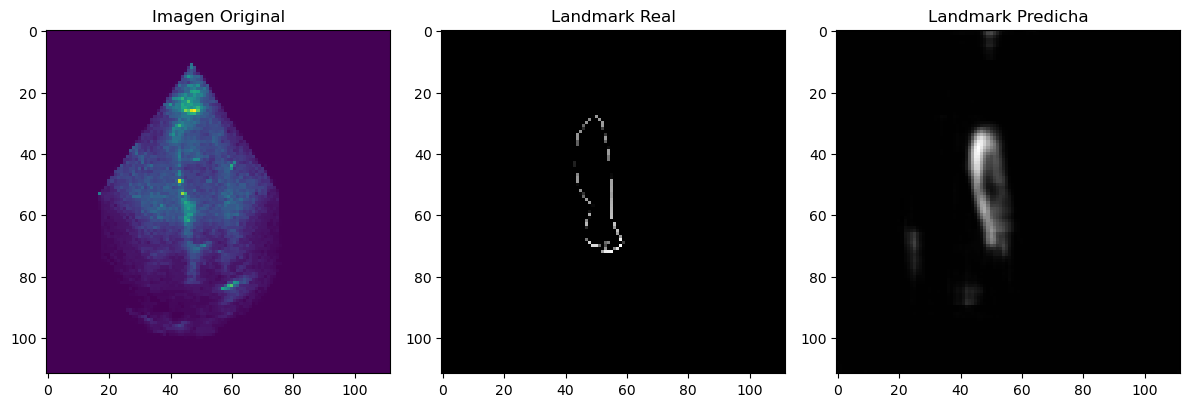


Porcentaje de similitud: 86.48294929791878%


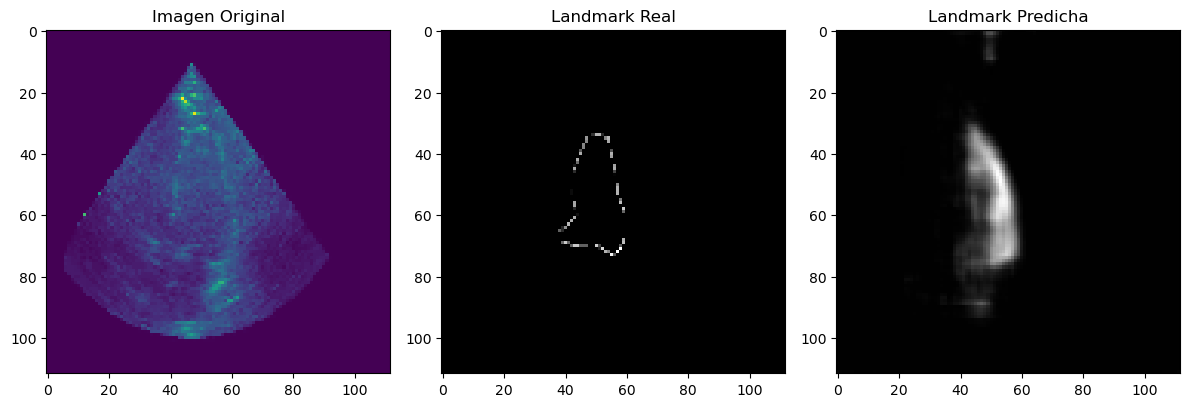


Porcentaje de similitud: 88.15224249406796%


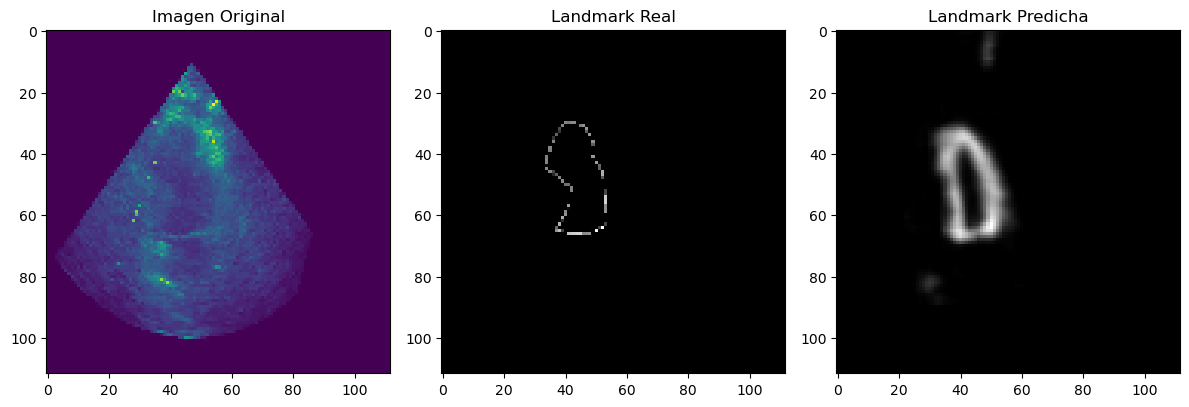


Porcentaje de similitud: 87.55584551713935%


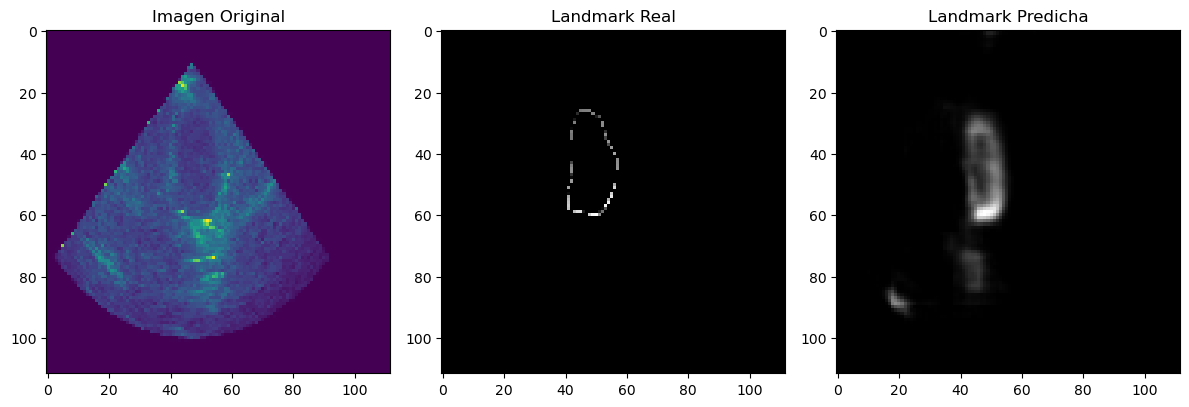


Porcentaje de similitud: 91.33980804914299%


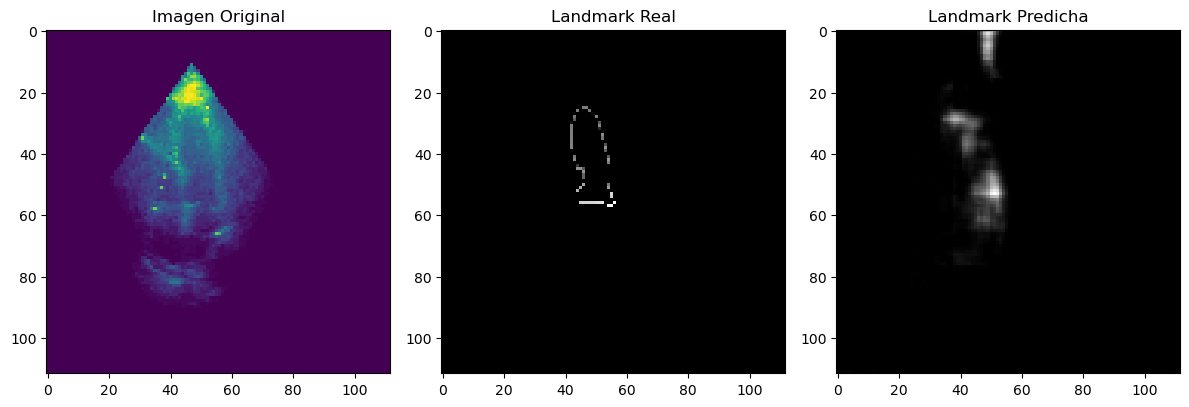


Porcentaje de similitud: 91.00776997802394%


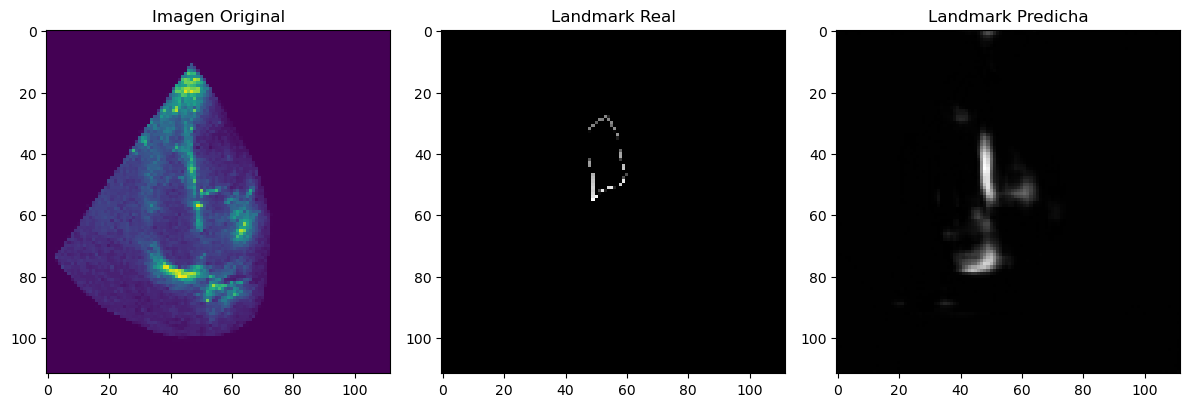


Porcentaje de similitud: 88.52093200338771%


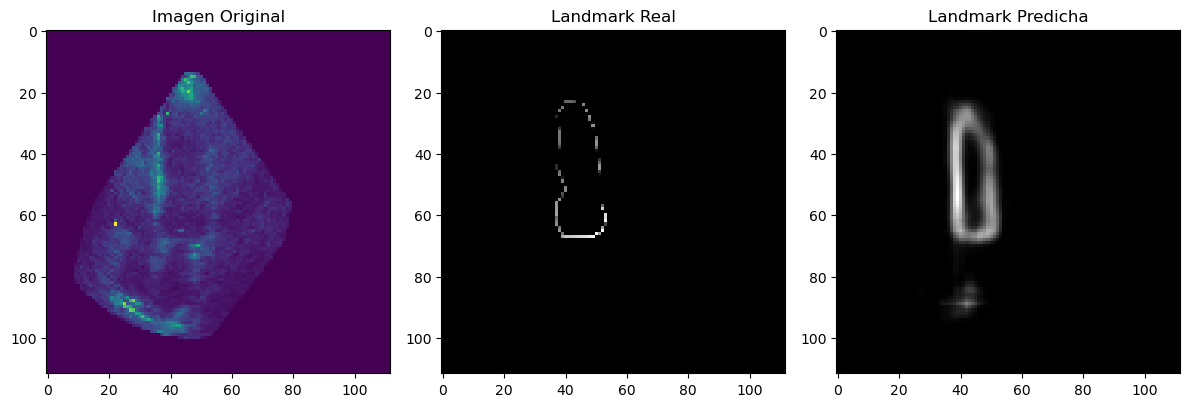


Porcentaje de similitud: 89.4414740044707%


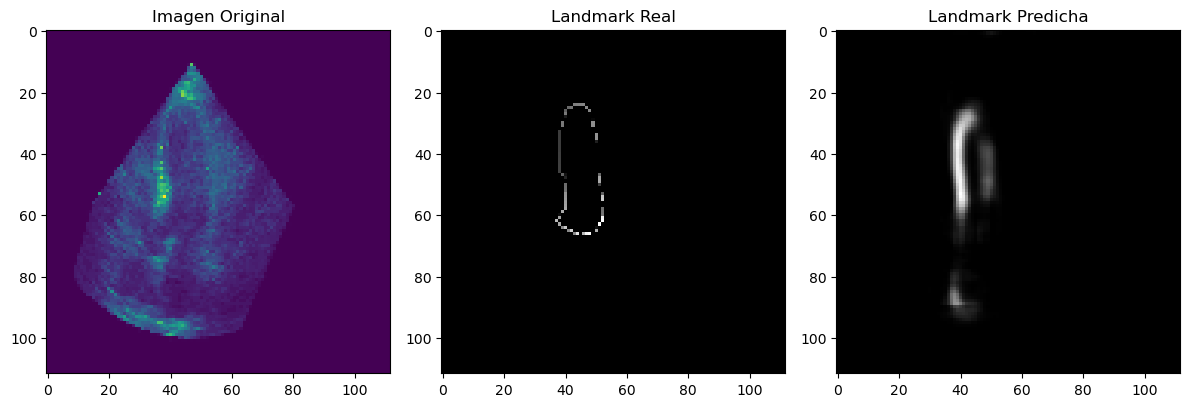


Porcentaje de similitud: 87.07958148242653%


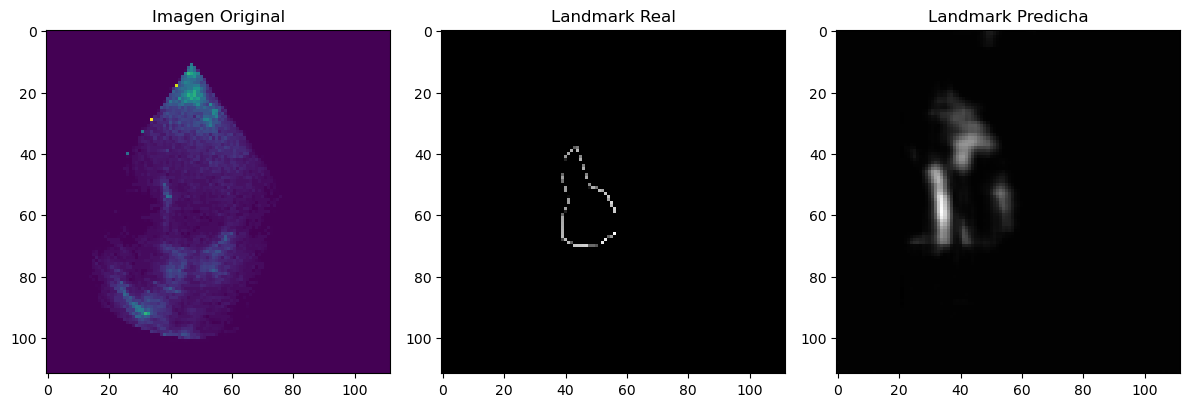


Porcentaje de similitud: 91.30541084719572%


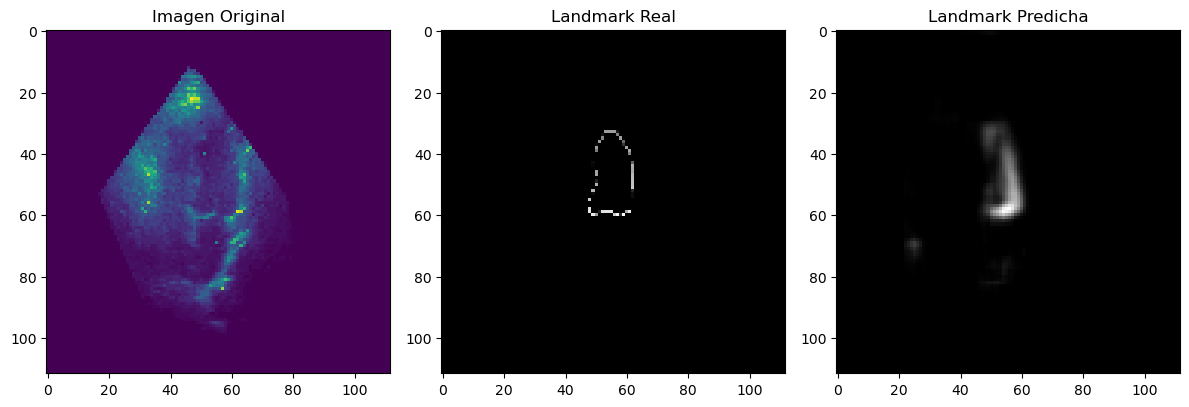


Porcentaje de similitud: 89.00759522790189%


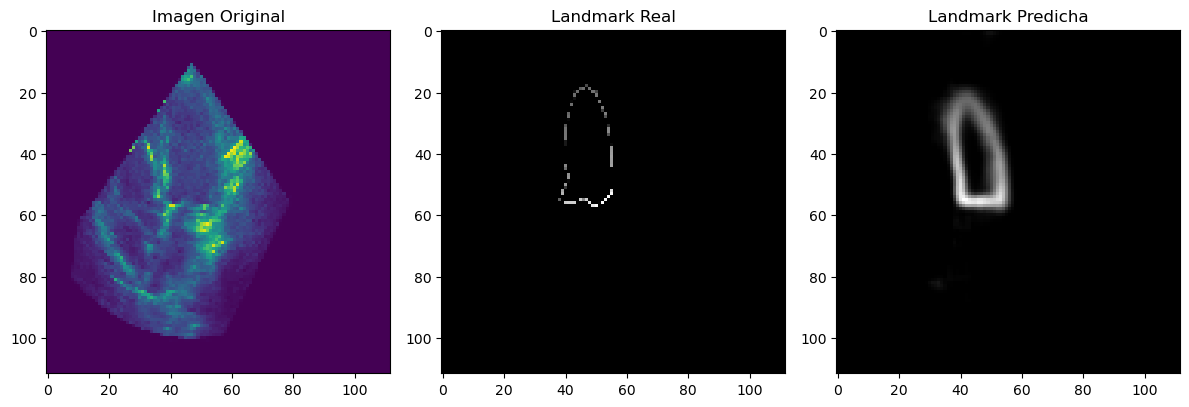


Porcentaje de similitud: 91.7513703732871%


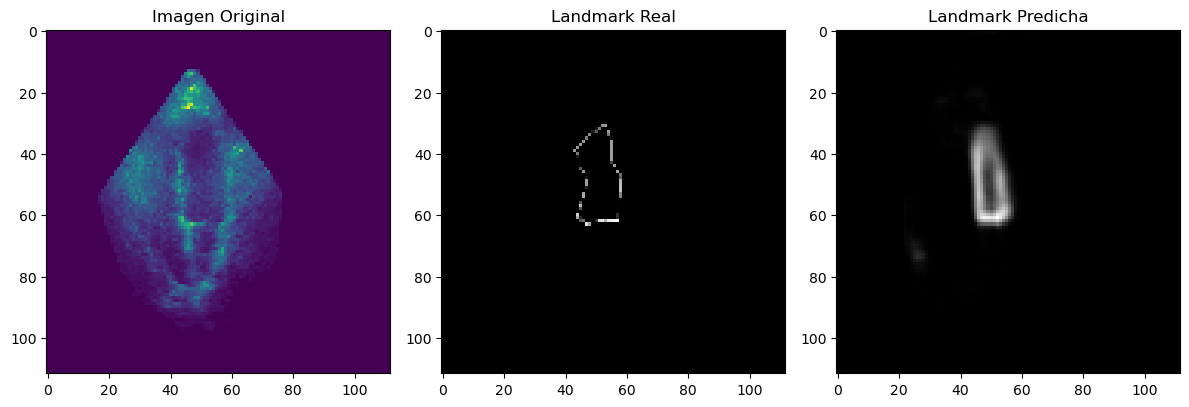


Porcentaje de similitud: 93.09759428212388%


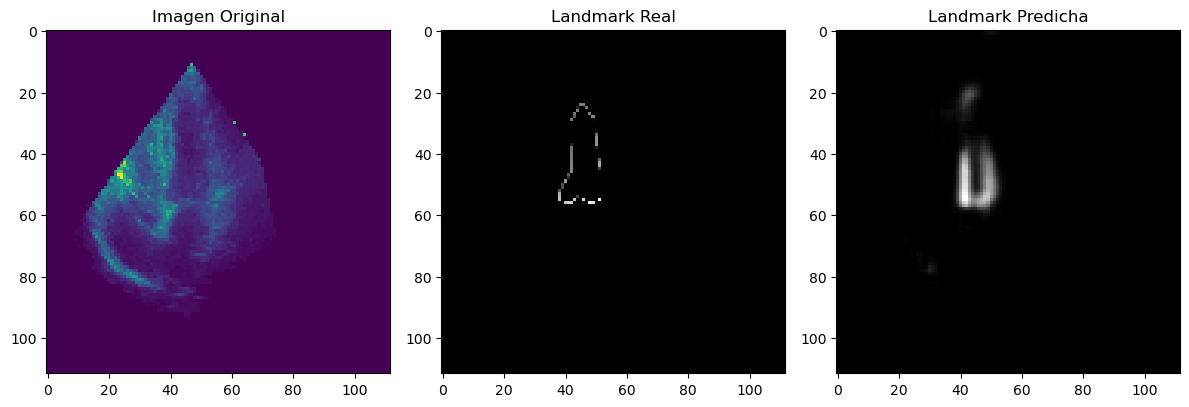


Porcentaje de similitud: 86.98342596857044%


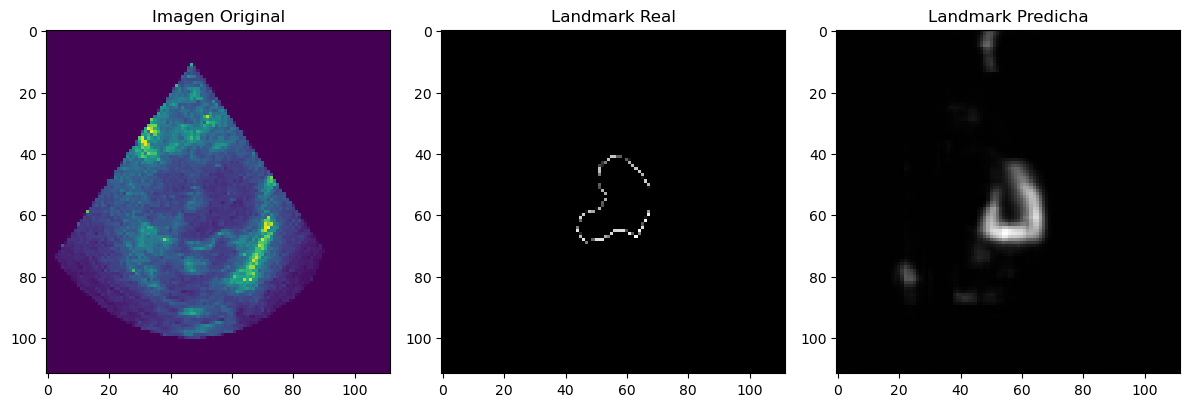


Porcentaje de similitud: 90.45843752587257%


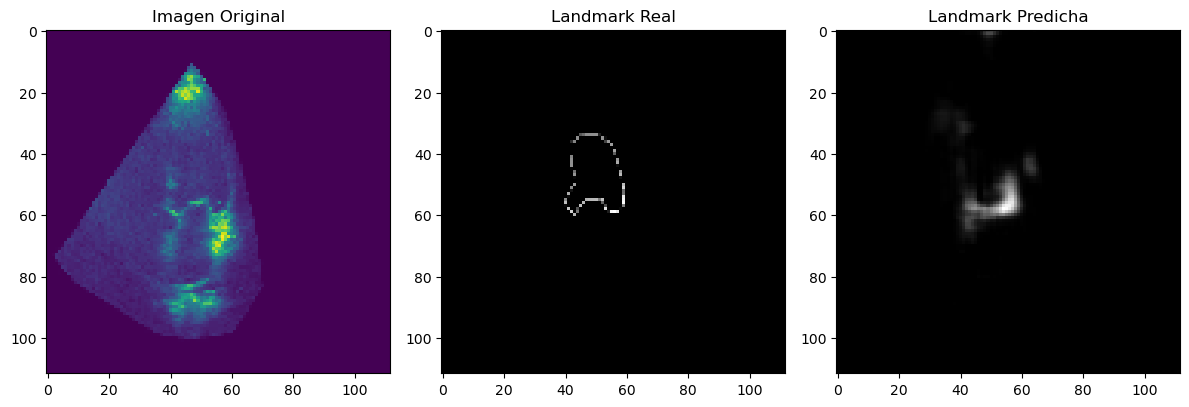

In [31]:
# Elije algunas muestras aleatorias para visualizar
num_samples_to_visualize = 15
sample_indices = np.random.choice(len(test_new_frames), num_samples_to_visualize, replace=False)

sample_images = [test_new_frames[i] for i in sample_indices]
sample_landmarks = [test_new_landmarks[i] for i in sample_indices]
sample_predictions = [predictions[i] for i in sample_indices]

# Llama a la función para visualizar las imágenes y máscaras
visualize_segmentation(sample_images, sample_landmarks, sample_predictions)

Porcentaje de similitud del modelo (promedio): 89.45958940698583%


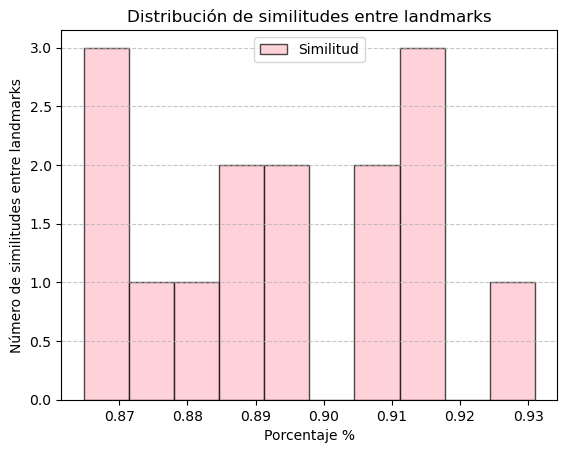

In [33]:
# Obtenemos el promedio de similitud de todo el conjunto de datos de test
landmarks_similarity = [calculate_similarity(np.mean(test_new_landmarks[i], axis=-1), np.mean(predictions[i], axis=-1)) for i in range(len(test_new_frames))]
landmarks_similarity_percentage = np.mean(landmarks_similarity)
print(f"Porcentaje de similitud del modelo (promedio): {landmarks_similarity_percentage * 100}%")

similarity_histogram(landmarks_similarity)